In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy
import regex as re

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    # dict(name="base", id="nml1-base", guard_replace = False, unnormalise = True), 
    dict(name="base_neutbndry", id="nml2-base-neutboundary", guard_replace = False, unnormalise = True), 
    dict(name="test", id="nml3-mom-loss-test", guard_replace = False, unnormalise = True), 
]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


# Convergence

In [3]:
lineplot?

Signature:
lineplot(
    cases,
    colors=None,
    params=['Td+', 'Te', 'Td', 'Ne', 'Nd'],
    regions=['imp', 'omp', 'outer_lower'],
    ylims=(None, None),
    xlims=(None, None),
    markersize=2,
    lw=2,
    dpi=120,
    clean_guards=True,
    logscale=True,
    log_threshold=10,
    save_name='',
    guard_replace=False,
    auto_y_pad=0.1,
    auto_y_pad_log=0.5,
)
Docstring: Versatile lineplot for 1D profiles in 2D models at OMP, IMP or target, as well as 1D models
File:      /ssd_scratch/scripts/sdtools/hermes3/plotting.py
Type:      function

/tmp/ipykernel_1747368/3160646912.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]


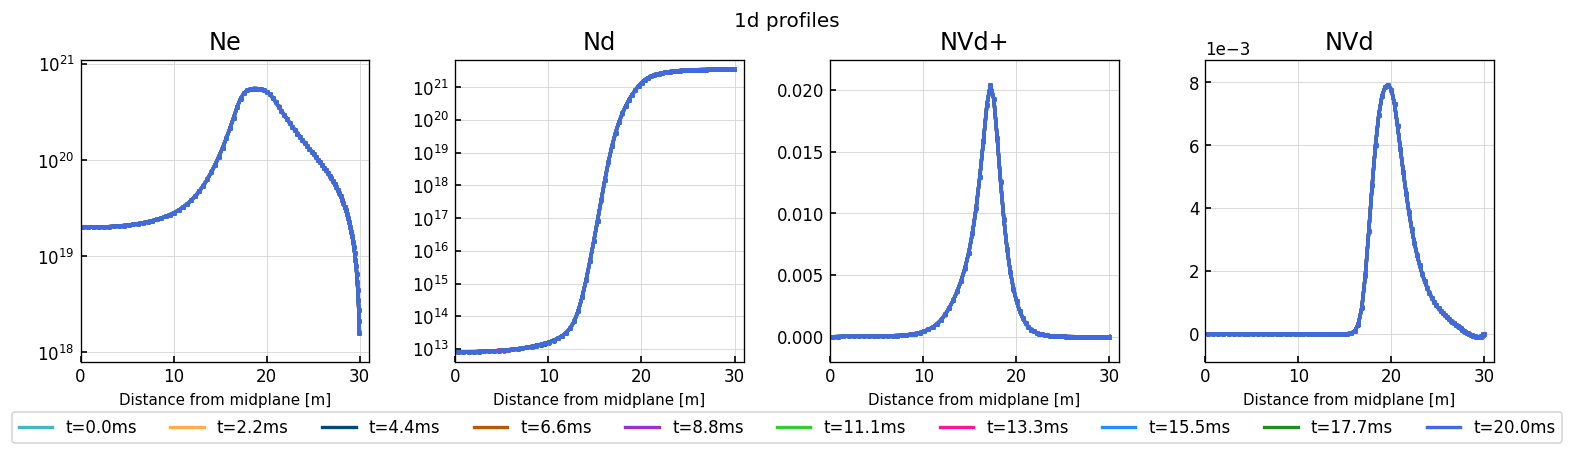

In [4]:
# ds = cs["base"].ds
# ds = cs["base_neutbndry"].ds
ds = cs["test"].ds

tlen = len(ds.coords["t"])
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]

toplot = {}
for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t)
    
lineplot(toplot, 
         params = ["Ne", "Nd", "NVd+", "NVd"],
         regions = ["1d"], xlims = (0,31))

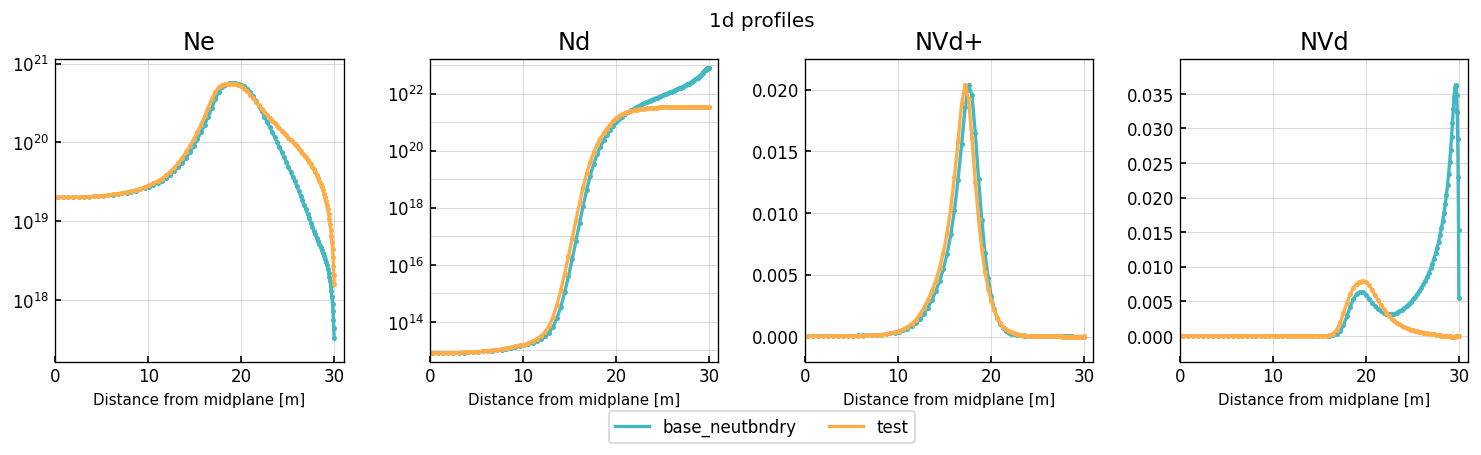

In [5]:
toplot = {}
for name in cs:
    toplot[name] = cs[name].ds
    
lineplot(toplot, 
         params = ["Ne", "Nd", "NVd+", "NVd"],
         regions = ["1d"], xlims = (0,31))

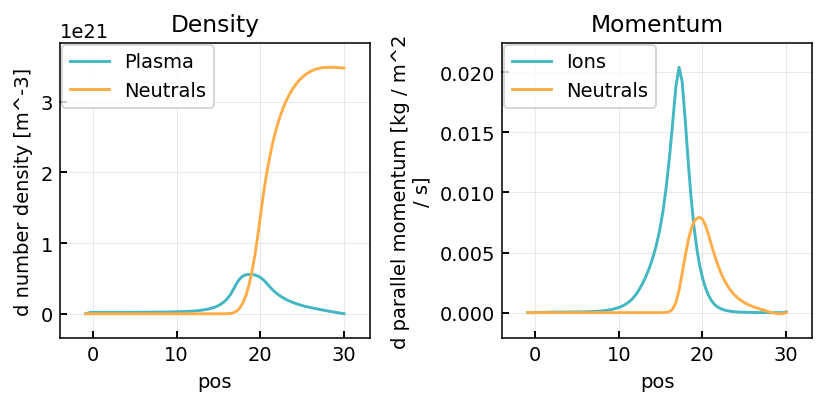

In [6]:
last = ds.isel(t=-1, pos = slice(None,-1))

fig, axes = plt.subplots(1,2, figsize = (6,3))
ax = axes[0]
last["Ne"].plot(ax = ax, label = "Plasma")
last["Nd"].plot(ax = ax, label = "Neutrals")
ax.set_title("Density")
ax.legend()

ax = axes[1]
last["NVd+"].plot(ax = ax, label = "Ions")
last["NVd"].plot(ax = ax, label = "Neutrals")
ax.set_title("Momentum")
ax.legend()
fig.tight_layout()

# Test

In [7]:
Pn_guard

NameError: name 'Pn_guard' is not defined

In [ ]:
guard["Pd"].values 


array(436.04807935)

In [ ]:
AA

2

In [ ]:
AA = ds.options["d"]["AA"]
target_energy_refl_factor = ds.options["d"]["target_energy_refl_factor"]
target_fast_refl_fraction = ds.options["d"]["target_fast_refl_fraction"]


last = ds.isel(t=-1, pos = -3)
guard = ds.isel(t=-1, pos = -2)
target = lambda x: 0.5 * (last[x].values + guard[x].values)

Nn_last = last["Nd"].values
Pn_last = last["Pd"].values
Tn_last = last["Td"].values

## Neumann
Nn_guard = last["Nd"].values
Pn_guard = last["Pd"].values
Tn_guard = last["Td"].values

np.testing.assert_allclose(Nn_guard, guard["Nd"].values, err_msg="Nn guard cell value")
np.testing.assert_allclose(Pn_guard, guard["Pd"].values, err_msg="Pn guard cell value")
np.testing.assert_allclose(Tn_guard, guard["Td"].values, err_msg="Tn guard cell value")

In [ ]:
target("Vd")

0.4457231737094392

In [ ]:
Nn_sheath = 0.5 * (Nn_guard + Nn_last)
Tn_sheath = 0.5 * (Tn_guard + Tn_last)
da_sheath = 0.5 * (guard["da"] + last["da"])

v_th = 0.25 * np.sqrt( 8*Tn_sheath / np.pi * AA)
T_FC = 3

heatflux_incident = 2 * Nn_sheath * Tn_sheath * v_th
heatflux_reflected_fast = (target_energy_refl_factor * target_fast_refl_fraction ) * 2 * Nn_sheath * Tn_sheath * v_th 
heatflux_reflected_thermal = (1 - target_fast_refl_fraction) * T_FC * Nn_sheath * v_th;
q = heatflux_incident - heatflux_reflected_fast - heatflux_reflected_thermal

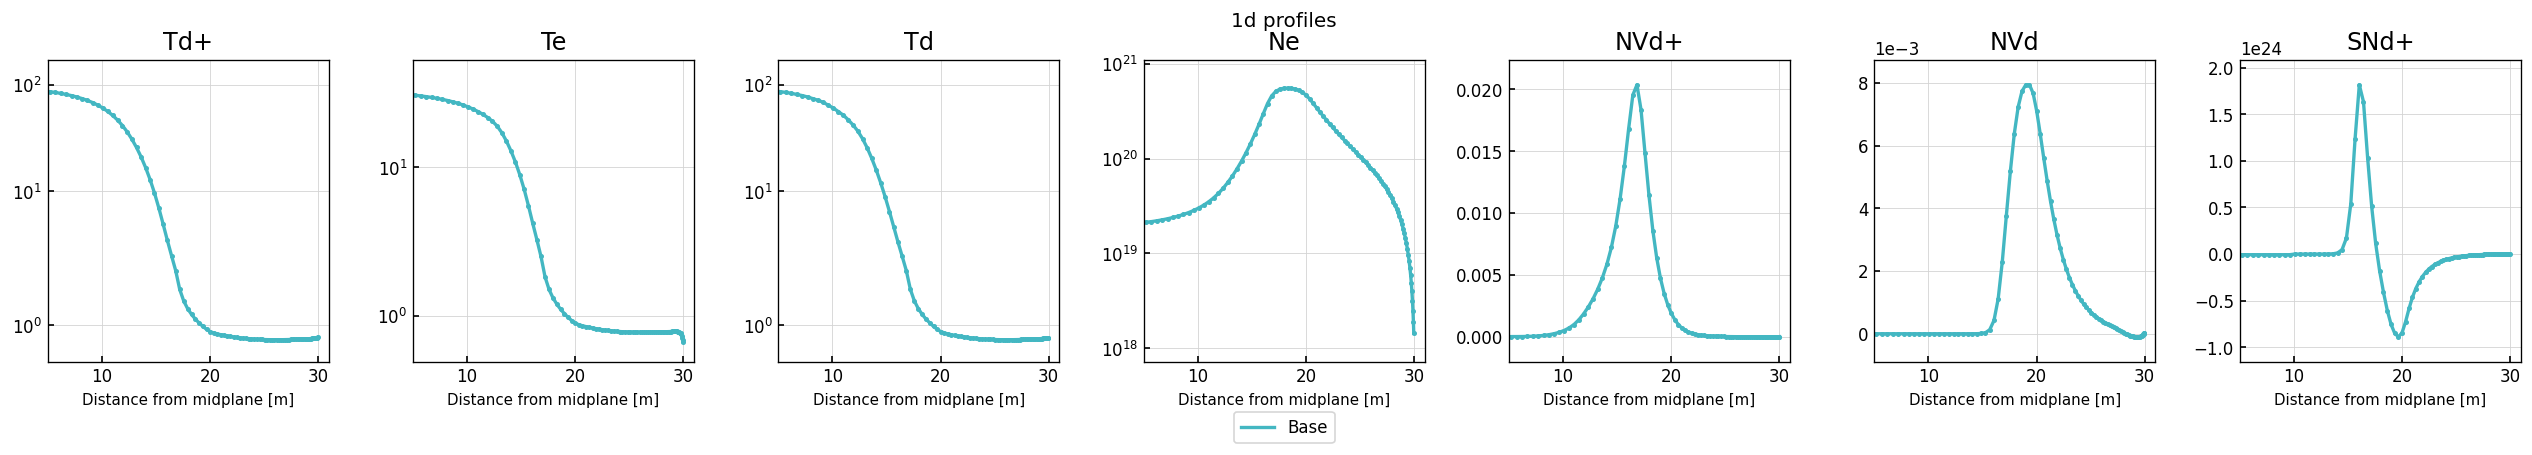

In [ ]:

toplot = {
    "Base" : cs["base"].ds.isel(t=-1), 
    # "No ar, limitFree" : cs["noar_limitFree"].ds.isel(t=-1), 
        }
lineplot(toplot, 
         params = ["Td+", "Te", "Td", "Ne", "NVd+", "NVd", "SNd+"],
         regions = ["1d"], xlims = (5,31))